In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"] = 100
plt.style.use("bmh")

In [3]:
os.chdir("../data/")

# Importowanie danych i ich przygotowanie

In [4]:
RANDOM_STATE = 0
TEST_SIZE = 0.2

In [5]:
df = pd.read_csv("totrain.csv", index_col=0)
df = df.drop("dl_polaczenia", axis=1)

In [6]:
X, y = df.drop("target", axis=1), df.target

#### train-test-validate split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
X_test, X_validate, y_test, y_validate = train_test_split(
    X_test, y_test, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

#### oversampling, bo zbior danych zawiera wiecej rekordow z targetem 0

In [8]:
serie = y_train.value_counts()
ratio = {1: serie[0] / serie[1]}
serie

0    21904
1     3097
Name: target, dtype: int64

In [9]:
df.head()

,wiek,wyksztalcenie,ma_kredyt,kredyt_mieszkaniowy,ma_pozyczke,miesiac,liczba_polaczen_aktualnej_kampanii,liczba_dni_od_ost_kontaktu,liczba_polaczen_przed_aktualna_kampania,wsk_zmien_zatrudnienia,wsk_cen_konsum,wsk_zauf_konsum,euribor3m,liczba_pracownikow,target,aktywnie_pracujacy,sposob_kontaktu_telephone,stan_cywilny_divorced,stan_cywilny_married,stan_cywilny_single,stan_cywilny_unknown,wynik_poprzedniej_kampanii_failure,wynik_poprzedniej_kampanii_nonexistent,wynik_poprzedniej_kampanii_success,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
0,1.774340,1,1,1,1,0.25,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0,0,0,0,0,0,0
1,-0.178868,4,1,0,1,0.25,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0
2,0.129533,2,1,1,1,0.25,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0
3,1.774340,4,1,1,0,0.25,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0
4,2.082742,5,1,1,1,0.25,1,6,0,2.406945,0.805097,0.882672,4.857,8.554682,0,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0


## Przygotowanie modeli

In [20]:
def build_model(model, name):
    global X_train, y_train, X_test, y_test, decomp
    plt.figure(dpi=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("-" * 3 + " " + name + " " + "-" * 3)
    print(classification_report(y_test, y_pred))
    print("-" * 10)
    print("Area under curve\n", roc_auc_score(y_test, y_pred))
    
    try:
        proba = model.predict_proba(X_test)[:, 1]
    except:
        proba = model.decision_function(X_test)
        
    fpr, tpr, *_ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, linestyle='--')
    print("-" * 10)
    print("Crosstab")
    print(pd.crosstab(y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]))

In [21]:
lr = LogisticRegression(max_iter=10000, class_weight=ratio)
svm = LinearSVC(C=0.0001, class_weight=ratio)
dtc = DecisionTreeClassifier(
    max_depth=10,
    random_state=RANDOM_STATE,
    class_weight=ratio,
)
rfc = RandomForestClassifier(
    n_estimators=10000,
    n_jobs=8,
    random_state=RANDOM_STATE,
    class_weight=ratio,
)
knn = KNeighborsClassifier(n_neighbors=50)

models = [
    (lr, "LogisticRegression"),
    (svm, "SVM"),
    (dtc, "DecisionTree"),
    (rfc, "RandomForest"),
]

### Ewaluacja modeli

--- KNN ---
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      4353
           1       0.71      0.23      0.35       647

    accuracy                           0.89      5000
   macro avg       0.80      0.61      0.64      5000
weighted avg       0.87      0.89      0.86      5000

----------
Area under curve
 0.608025306145347
----------
Crosstab
Predicted     0    1
Actual              
0          4291   62
1           498  149


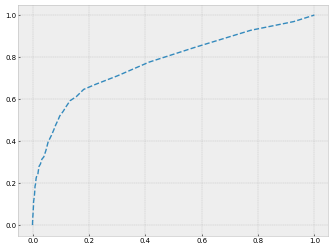

In [22]:
build_model(knn, "KNN")

--- LogisticRegression ---
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      4353
           1       0.32      0.68      0.44       647

    accuracy                           0.77      5000
   macro avg       0.63      0.73      0.65      5000
weighted avg       0.86      0.77      0.80      5000

----------
Area under curve
 0.7339808286562484
----------
Crosstab
Predicted     0    1
Actual              
0          3423  930
1           206  441


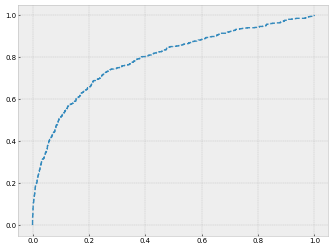

In [18]:
build_model(lr, "LogisticRegression")

--- SupportedVectorMachines ---
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      4353
           1       0.28      0.73      0.41       647

    accuracy                           0.72      5000
   macro avg       0.62      0.73      0.61      5000
weighted avg       0.86      0.72      0.77      5000

----------
Area under curve
 0.7286685335949447
----------
Crosstab
Predicted     0     1
Actual               
0          3148  1205
1           172   475


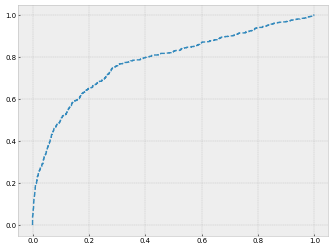

In [23]:
build_model(svm, "SupportedVectorMachines")

--- DecisionTreeClassifier ---
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      4353
           1       0.39      0.58      0.47       647

    accuracy                           0.83      5000
   macro avg       0.66      0.72      0.68      5000
weighted avg       0.86      0.83      0.84      5000

----------
Area under curve
 0.7246927006939022
----------
Crosstab
Predicted     0    1
Actual              
0          3766  587
1           269  378


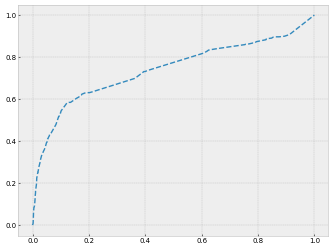

In [24]:
build_model(dtc, "DecisionTreeClassifier")

In [ ]:
build_model(rfc, "RandomForestClassifier")

#### Na podstawie powyższych wyników, możemy zaobserwować, że najlepszym wyborem będzie algorytm _Decision tree_.

In [ ]:
n_components = list(range(1, X.shape[1] + 1, 1))
criterion = ["gini", "entropy"]
max_depth = list(range(2, 51, 2))
parameters = dict(
    criterion=criterion,
    max_depth=max_depth,
    class_weight=[ratio],
    max_features=["sqrt", "auto"],
)

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(), parameters, scoring="f1")

#### Walidacja na podstawie wcześniejszego "odłożenia" podzbioru z suffixem _validate_

In [ ]:
gs.fit(X_validate, y_validate)

In [ ]:
gs.best_params_

In [ ]:
dct = DecisionTreeClassifier(
    max_features="sqrt", max_depth=8, criterion="entropy", class_weight=ratio
)
build_model(dct, "DCT")

# Wnioski

Podstawowe algorytmy do binarnej klasyfikacji, okazały się być niewystarczające. 